# Visual Content Search using MobileCLIP and OpenVINO

Semantic visual content search is a machine learning task that uses either a text query or an input image to search a database of images (photo gallery, video) to find images that are semantically similar to the search query. 
Historically, building a robust search engine for images was difficult. One could search by features such as file name and image metadata, and use any context around an image (i.e. alt text or surrounding text if an image appears in a passage of text) to provide the richer searching feature. This was before the advent of neural networks that can identify semantically related images to a given user query.

[Contrastive Language-Image Pre-Training (CLIP)](https://arxiv.org/abs/2103.00020) models provide the means through which you can implement a semantic search engine with a few dozen lines of code. The CLIP model has been trained on millions of pairs of text and images, encoding semantics from images and text combined. Using CLIP, you can provide a text query and CLIP will return the images most related to the query.

In this tutorial, we consider how to use MobileCLIP to implement a visual content search engine for finding relevant frames in video. 
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Run model inference](#Run-model-inference)
    - [Prepare image gallery](#Prepare-image-gallery)
    - [Prepare model](#Prepare-model)
    - [Perform search](#Perform-search)
- [Convert Model to OpenVINO Intermediate Representation format](#Convert-Model-to-OpenVINO-Intermediate-Representation-format)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select device for image encoder](#Select-device-for-image-encoder)
    - [Select device for text encoder](#Select-device-for-text-encoder)
    - [Perform search](#Perform-search)
- [Interactive Demo](#Interactive-Demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/mobileclip-video-search/mobileclip-video-search.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
from pathlib import Path

repo_dir = Path("./ml-mobileclip")

if not repo_dir.exists():
    !git clone https://github.com/apple/ml-mobileclip.git

In [2]:
%pip install -q "./ml-mobileclip" --no-deps

%pip install -q "clip-benchmark>=1.4.0" "datasets>=2.8.0" "open-clip-torch>=2.20.0" "timm>=0.9.5" "torch>=1.13.1" "torchvision>=0.14.1" --extra-index-url https://download.pytorch.org/whl/cpu

%pip install -q "openvino>=2024.0.0" "gradio>=4.19" "matplotlib" "Pillow"  "altair" "pandas" "opencv-python" "tqdm" "salesforce-lavis>=1.0.2"

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mobileclip 0.1.0 requires torch==1.13.1, but you have torch 2.3.1+cpu which is incompatible.
mobileclip 0.1.0 requires torchvision==0.14.1, but you have torchvision 0.18.1+cpu which is incompatible.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-llms-huggingface 0.2.8 requires transformers[torch]<5.0.0,>=4.37.0, but you have transformers 4.26.1 which is incompatible.
mobileclip 0.1.0 requires timm>=0.9.5, but you have timm 0.4.12 which is incompatible.
mobileclip 0.1.0 requires torch==1.13.1, but you have torch 2.3.1+cpu which is incompatible.
mob

## Select model
[back to top ⬆️](#Table-of-contents:)

For starting work, we should select model that will be used in our demonstration.
By default, we will use the MobileCLIP model, but for comparison purposes, you can select different models among:

* **CLIP** - CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.
CLIP uses a [ViT](https://arxiv.org/abs/2010.11929) like transformer to get visual features and a causal language model to get the text features. The text and visual features are then projected into a latent space with identical dimensions. The dot product between the projected image and text features is then used as a similarity score. You can find more information about this model in the [research paper](https://arxiv.org/abs/2103.00020), [OpenAI blog](https://openai.com/blog/clip/), [model card](https://github.com/openai/CLIP/blob/main/model-card.md) and GitHub [repository](https://github.com/openai/CLIP).
* **SigLIP** -  The SigLIP model was proposed in [Sigmoid Loss for Language Image Pre-Training](https://arxiv.org/abs/2303.15343). SigLIP proposes to replace the loss function used in [CLIP](https://github.com/openai/CLIP) (Contrastive Language–Image Pre-training) by a simple pairwise sigmoid loss. This results in better performance in terms of zero-shot classification accuracy on ImageNet. You can find more information about this model in the [research paper](https://arxiv.org/abs/2303.15343) and [GitHub repository](https://github.com/google-research/big_vision),
* **MobileCLIP** -  MobileCLIP – a new family of efficient image-text models optimized for runtime performance along with a novel and efficient training approach, namely multi-modal reinforced training. The smallest variant MobileCLIP-S0 obtains similar zero-shot performance as OpenAI's CLIP ViT-b16 model while being several times faster and 2.8x smaller. More details about model can be found in [research paper](https://arxiv.org/pdf/2311.17049.pdf) and [GitHub repository](https://github.com/apple/ml-mobileclip).
* **BLIP-2** - BLIP2 was introduced in the paper [BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models](https://arxiv.org/abs/2301.12597) by Li et al. and first released in this [repository](https://github.com/salesforce/LAVIS/tree/main/projects/blip2). It is a generic and efficient pre-training strategy that easily harvests development of pretrained vision models and large language models (LLMs) for vision-language pretraining. BLIP-2 consists of 3 models: a CLIP-like image encoder, a Querying Transformer (Q-Former) and a large language model.

In [2]:
import ipywidgets as widgets

model_dir = Path("checkpoints")

supported_models = {
    "MobileCLIP": {
        "mobileclip_s0": {
            "model_name": "mobileclip_s0",
            "pretrained": model_dir / "mobileclip_s0.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt",
            "image_size": 256,
        },
        "mobileclip_s1": {
            "model_name": "mobileclip_s1",
            "pretrained": model_dir / "mobileclip_s1.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s1.pt",
            "image_size": 256,
        },
        "mobileclip_s2": {
            "model_name": "mobileclip_s0",
            "pretrained": model_dir / "mobileclip_s2.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s2.pt",
            "image_size": 256,
        },
        "mobileclip_b": {
            "model_name": "mobileclip_b",
            "pretrained": model_dir / "mobileclip_b.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_b.pt",
            "image_size": 224,
        },
        "mobileclip_blt": {
            "model_name": "mobileclip_b",
            "pretrained": model_dir / "mobileclip_blt.pt",
            "url": "https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt",
            "image_size": 224,
        },
    },
    "CLIP": {
        "clip-vit-b-32": {
            "model_name": "ViT-B-32",
            "pretrained": "laion2b_s34b_b79k",
            "image_size": 224,
        },
        "clip-vit-b-16": {
            "image_name": "ViT-B-16",
            "pretrained": "openai",
            "image_size": 224,
        },
        "clip-vit-l-14": {
            "image_name": "ViT-L-14",
            "pretrained": "datacomp_xl_s13b_b90k",
            "image_size": 224,
        },
        "clip-vit-h-14": {
            "image_name": "ViT-H-14",
            "pretrained": "laion2b_s32b_b79k",
            "image_size": 224,
        },
    },
    "SigLIP": {
        "siglip-vit-b-16": {
            "model_name": "ViT-B-16-SigLIP",
            "pretrained": "webli",
            "image_size": 224,
        },
        "siglip-vit-l-16": {
            "model_name": "ViT-L-16-SigLIP-256",
            "pretrained": "webli",
            "image_size": 256,
        },
    },
    "Blip2": {
        "blip2_feature_extractor": {
            "model_name": "blip2_feature_extractor",
            "pretrained": "pretrain_vitL",
            "image_size": 224,
        },
    },
}


model_type = widgets.Dropdown(options=supported_models.keys(), default="MobileCLIP", description="Model type:")
model_type

Dropdown(description='Model type:', options=('MobileCLIP', 'CLIP', 'SigLIP', 'Blip2'), value='MobileCLIP')

In [3]:
available_models = supported_models[model_type.value]

model_checkpoint = widgets.Dropdown(
    options=available_models.keys(),
    default=list(available_models),
    description="Model:",
)

model_checkpoint

Dropdown(description='Model:', options=('blip2_feature_extractor',), value='blip2_feature_extractor')

In [4]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, device_widget

model_config = available_models[model_checkpoint.value]

## Run model inference
[back to top ⬆️](#Table-of-contents:)

Now, let's see model in action. We will try to find image, where some specific object is represented using embeddings. Embeddings are a numeric representation of data such as text and images. The model learned to encode semantics about the contents of images in embedding format. This ability turns the model into a powerful for solving various tasks including image-text retrieval. To reach our goal we should:

1.  Calculate embeddings for all of the images in our dataset;
2.  Calculate a text embedding for a user query (i.e. "black dog" or "car");
3.  Compare the text embedding to the image embeddings to find related embeddings.

The closer two embeddings are, the more similar the contents they represent are.

### Prepare image gallery
[back to top ⬆️](#Table-of-contents:)

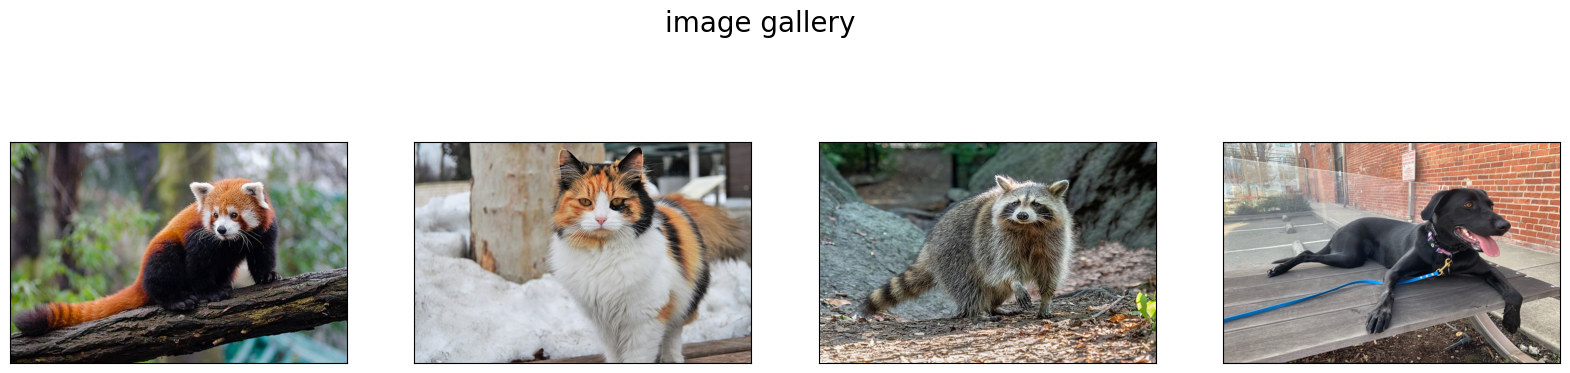

In [5]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(images: List, query: str = "", selected: List[int] = None):
    """
    Utility function for visualization classification results
    params:
      images (List[Image]) - list of images for visualization
      query (str) - title for visualization
      selected (List[int]) - list of selected image indices from images
    returns:
      matplotlib.Figure
    """
    figsize = (20, 5)
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharex="all", sharey="all")
    fig.patch.set_facecolor("white")
    list_axes = list(axs.flat)
    if query:
        fig.suptitle(query, fontsize=20)
    for idx, a in enumerate(list_axes):
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
        a.imshow(images[idx])
        if selected is not None and idx not in selected:
            mask = np.ones_like(np.array(images[idx]))
            a.imshow(mask, "jet", interpolation="none", alpha=0.75)
    return fig


images_urls = [
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/282ce53e-912d-41aa-ab48-2a001c022d74",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/9bb40168-82b5-4b11-ada6-d8df104c736c",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/0747b6db-12c3-4252-9a6a-057dcf8f3d4e",
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bricks.png",
]
image_names = ["red_panda.png", "cat.png", "raccoon.png", "dog.png"]
sample_path = Path("data")
sample_path.mkdir(parents=True, exist_ok=True)

images = []
for image_name, image_url in zip(image_names, images_urls):
    image_path = sample_path / image_name
    if not image_path.exists():
        download_file(image_url, filename=image_name, directory=sample_path)
    images.append(Image.open(image_path).convert("RGB").resize((640, 420)))

input_labels = ["cat"]
text_descriptions = [f"This is a photo of a {label}" for label in input_labels]

visualize_result(images, "image gallery");

### Prepare model
[back to top ⬆️](#Table-of-contents:)

The code bellow download model weights, create model class instance and preprocessing utilities

In [22]:
import torch


class blip2model(torch.nn.Module):
    def __init__(self, ln_vision, visual_encoder, query_tokens, Qformer, vision_proj, text_proj, tokenizer):
        super().__init__()
        self.ln_vision = ln_vision
        self.visual_encoder = visual_encoder
        self.query_tokens = query_tokens
        self.Qformer = Qformer
        self.vision_proj = vision_proj
        self.text_proj = text_proj
        self.tokenizer = tokenizer

    def encode_image(self, image):
        image_embeds_frozen = self.ln_vision(self.visual_encoder(image))
        image_embeds_frozen = image_embeds_frozen.float()
        image_atts = torch.ones(image_embeds_frozen.size()[:-1], dtype=torch.long)
        query_tokens = self.query_tokens.expand(image_embeds_frozen.shape[0], -1, -1)

        query_output = self.Qformer.bert(
            query_embeds=query_tokens,
            encoder_hidden_states=image_embeds_frozen,
            encoder_attention_mask=image_atts,
            return_dict=True,
        )
        image_embeds = query_output.last_hidden_state
        image_features = self.vision_proj(image_embeds)

        return image_features

    def encode_text(self, input_ids, attention_mask):
        text_output = self.Qformer.bert(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True,
        )
        text_embeds = text_output.last_hidden_state
        text_features = self.text_proj(text_embeds)
        return text_features

In [23]:
import torch
import time
import mobileclip
import open_clip

# instantiate model
model_name = model_config["model_name"]
pretrained = model_config["pretrained"]

if model_type.value == "MobileCLIP":
    model_dir.mkdir(exist_ok=True)
    model_url = model_config["url"]
    download_file(model_url, directory=model_dir)
    model, _, preprocess = mobileclip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = mobileclip.get_tokenizer(model_name)
elif model_type.value == "Blip2":
    from lavis.models import load_model_and_preprocess

    model, vis_processors, txt_processors = load_model_and_preprocess(name=model_name, model_type=pretrained, is_eval=True)
    model = blip2model(model.ln_vision, model.visual_encoder, model.query_tokens, model.Qformer, model.vision_proj, model.text_proj, model.tokenizer)
    preprocess = vis_processors["eval"]
    tokenizer = model.tokenizer
else:
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
    tokenizer = open_clip.get_tokenizer(model_name)

### Perform search
[back to top ⬆️](#Table-of-contents:)

In [ ]:
image_tensor = torch.stack([preprocess(image) for image in images])
if model_type.value == "Blip2":
    input_ids = tokenizer(text_descriptions, return_tensors="pt", padding=True).input_ids
    attention_mask = tokenizer(text_descriptions, return_tensors="pt", padding=True).attention_mask
    text = {"input_ids": input_ids, "attention_mask": attention_mask}
else:
    text = tokenizer(text_descriptions)

with torch.no_grad():
    # calculate image embeddings
    image_encoding_start = time.perf_counter()
    image_features = model.encode_image(image_tensor)
    image_encoding_end = time.perf_counter()
    print(f"Image encoding took {image_encoding_end - image_encoding_start:.3} ms")
    # calculate text embeddings
    text_encoding_start = time.perf_counter()
    if model_type.value == "Blip2":
        text_features = model.encode_text(**text)
    else:
        text_features = model.encode_text(text)
    text_encoding_end = time.perf_counter()
    print(f"Text encoding took {text_encoding_end - text_encoding_start:.3} ms")

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    if model_type.value == "Blip2":
        image_probs = image_features[:, 0, :] @ text_features[:, 0, :].t()
    else:
        image_probs = (100.0 * text_features @ image_features.T).softmax(dim=-1)
    selected_image = [torch.argmax(image_probs).item()]

visualize_result(images, input_labels[0], selected_image);

## Convert Model to OpenVINO Intermediate Representation format
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions.

Our model consist from 2 parts - image encoder and text encoder that can be used separately. Let's convert each part to OpenVINO.

In [25]:
import types
import torch.nn.functional as F


def se_block_forward(self, inputs):
    """Apply forward pass."""
    b, c, h, w = inputs.size()
    x = F.avg_pool2d(inputs, kernel_size=[8, 8])
    x = self.reduce(x)
    x = F.relu(x)
    x = self.expand(x)
    x = torch.sigmoid(x)
    x = x.view(-1, c, 1, 1)
    return inputs * x

In [26]:
import openvino as ov
import gc

ov_models_dir = Path("ov_models")
ov_models_dir.mkdir(exist_ok=True)

image_encoder_path = ov_models_dir / f"{model_checkpoint.value}_im_encoder.xml"

if not image_encoder_path.exists():
    if "mobileclip_s" in model_name:
        model.image_encoder.model.conv_exp.se.forward = types.MethodType(se_block_forward, model.image_encoder.model.conv_exp.se)
    model.forward = model.encode_image
    ov_image_encoder = ov.convert_model(
        model,
        example_input=image_tensor,
        input=[-1, 3, image_tensor.shape[2], image_tensor.shape[3]],
    )
    ov.save_model(ov_image_encoder, image_encoder_path)
    del ov_image_encoder
    gc.collect()

text_encoder_path = ov_models_dir / f"{model_checkpoint.value}_text_encoder.xml"

if not text_encoder_path.exists():
    model.forward = model.encode_text
    if model_type.value == "Blip2":
        ov_text_encoder = ov.convert_model(model, example_input=text)
    else:
        ov_text_encoder = ov.convert_model(model, example_input=text, input=[-1, text.shape[1]])
    ov.save_model(ov_text_encoder, text_encoder_path)
    del ov_text_encoder
    gc.collect()

del model
gc.collect();

/home2/ethan/intel/openvino_notebooks/openvino_env/lib/python3.10/site-packages/lavis/models/blip2_models/Qformer.py:429: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if query_length > 0:
/home2/ethan/intel/openvino_notebooks/openvino_env/lib/python3.10/site-packages/lavis/models/blip2_models/Qformer.py:455: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attention_output.shape[1] > query_length:


## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

### Select device for image encoder
[back to top ⬆️](#Table-of-contents:)

In [27]:
core = ov.Core()

device = device_widget()

device

[ERROR] 09:27:28.419 [NPUBackends] Cannot find backend for inference. Make sure the device is available.


Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [28]:
ov_compiled_image_encoder = core.compile_model(image_encoder_path, device.value)
ov_compiled_image_encoder(image_tensor);

[ERROR] 09:27:28.428 [NPUBackends] Cannot find backend for inference. Make sure the device is available.


### Select device for text encoder
[back to top ⬆️](#Table-of-contents:)

In [29]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [30]:
ov_compiled_text_encoder = core.compile_model(text_encoder_path, device.value)
ov_compiled_text_encoder(text);

### Perform search
[back to top ⬆️](#Table-of-contents:)

In [ ]:
image_encoding_start = time.perf_counter()
image_features = torch.from_numpy(ov_compiled_image_encoder(image_tensor)[0])
image_encoding_end = time.perf_counter()
print(f"Image encoding took {image_encoding_end - image_encoding_start:.3} ms")
text_encoding_start = time.perf_counter()
text_features = torch.from_numpy(ov_compiled_text_encoder(text)[0])
text_encoding_end = time.perf_counter()
print(f"Text encoding took {text_encoding_end - text_encoding_start:.3} ms")
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

if model_type.value == "Blip2":
    image_probs = image_features[:, 0, :] @ text_features[:, 0, :].t()
else:
    image_probs = (100.0 * text_features @ image_features.T).softmax(dim=-1)
selected_image = [torch.argmax(image_probs).item()]

visualize_result(images, input_labels[0], selected_image);

### (optional) Translation model 

Since BLIP-2 natively supports input in English only, we can insert a translation model in this pipeline to support searching in Chinese.

In [32]:
%pip install -q "torch>=2.1.0" "git+https://github.com/huggingface/optimum-intel.git" "transformers>=4.33.0" --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [33]:
from pathlib import Path

trans_model_path = "ov_models/trans_model"
trans_model_id = "Helsinki-NLP/opus-mt-zh-en"

if not Path(trans_model_path).exists():
    !optimum-cli export openvino --model {trans_model_id} --task text2text-generation-with-past --trust-remote-code {trans_model_path}

## Interactive Demo
[back to top ⬆️](#Table-of-contents:)

In this part, you can try different supported by tutorial models in searching frames in the video by text query or image. Upload video and provide text query or reference image for search and model will find the most relevant frames according to provided query. Please note, different models can require different optimal threshold for search. 

In [34]:
from transformers import AutoTokenizer
from optimum.intel import OVModelForSeq2SeqLM

tr_tokenizer = AutoTokenizer.from_pretrained(trans_model_path)
tr_model = OVModelForSeq2SeqLM.from_pretrained(trans_model_path)

/home2/ethan/intel/openvino_notebooks/openvino_env/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Compiling the encoder to CPU ...
Compiling the decoder to CPU ...
Compiling the decoder to CPU ...


In [40]:
import altair as alt
import cv2
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Resize,
    ToTensor,
)
from open_clip.transform import image_transform
from typing import Optional


current_device = device.value
current_model = image_encoder_path.name.split("_im_encoder")[0]

available_converted_models = [model_file.name.split("_im_encoder")[0] for model_file in ov_models_dir.glob("*_im_encoder.xml")]
available_devices = list(core.available_devices) + ["AUTO"]

download_file(
    "https://github.com/intel-iot-devkit/sample-videos/raw/master/car-detection.mp4",
    directory=sample_path,
)
download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4",
    directory=sample_path,
    filename="coco.mp4",
)


def is_english(text):
    for char in text:
        if not char.isascii():
            return False
    return True


def translate(text):
    if tr_tokenizer:
        t = tr_tokenizer(text, return_tensors="pt")
        r = tr_model.generate(**t)
        text = tr_tokenizer.decode(r[0][1:-1])  # skipping <pad> and </s>
    return text


def get_preprocess_and_tokenizer(model_name):
    if "mobileclip" in model_name:
        resolution = supported_models["MobileCLIP"][model_name]["image_size"]
        resize_size = resolution
        centercrop_size = resolution
        aug_list = [
            Resize(
                resize_size,
                interpolation=InterpolationMode.BILINEAR,
            ),
            CenterCrop(centercrop_size),
            ToTensor(),
        ]
        preprocess = Compose(aug_list)
        tokenizer = mobileclip.get_tokenizer(supported_models["MobileCLIP"][model_name]["model_name"])
    elif "blip2" in model_name:
        from lavis.models import load_model_and_preprocess

        model, vis_processors, txt_processors = load_model_and_preprocess(name=model_name, model_type=pretrained, is_eval=True)
        preprocess = vis_processors["eval"]
        tokenizer = model.tokenizer
    else:
        model_configs = supported_models["SigLIP"] if "siglip" in model_name else supported_models["CLIP"]
        resize_size = model_configs[model_name]["image_size"]
        preprocess = image_transform((resize_size, resize_size), is_train=False, resize_mode="longest")
        tokenizer = open_clip.get_tokenizer(model_configs[model_name]["model_name"])

    return preprocess, tokenizer


def run(
    path: str,
    text_search: str,
    image_search: Optional[Image.Image],
    model_name: str,
    device: str,
    thresh: float,
    stride: int,
    batch_size: int,
):
    assert path, "An input video should be provided"
    assert text_search is not None or image_search is not None, "A text or image query should be provided"
    global current_model
    global current_device
    global preprocess
    global tokenizer
    global ov_compiled_image_encoder
    global ov_compiled_text_encoder

    if current_model != model_name or device != current_device:
        ov_compiled_image_encoder = core.compile_model(ov_models_dir / f"{model_name}_im_encoder.xml", device)
        ov_compiled_text_encoder = core.compile_model(ov_models_dir / f"{model_name}_text_encoder.xml", device)
        preprocess, tokenizer = get_preprocess_and_tokenizer(model_name)
        current_model = model_name
        current_device = device
    # Load video
    dataset = LoadVideo(path, transforms=preprocess, vid_stride=stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Get image query features
    if image_search:
        image = preprocess(image_search).unsqueeze(0)
        query_features = torch.from_numpy(ov_compiled_image_encoder(image)[0])
        query_features /= query_features.norm(dim=-1, keepdim=True)
    # Get text query features
    else:
        if not is_english(text_search):
            text_search = translate(text_search)
            print(f"Translated input text: {text_search}")
        # Tokenize search phrase
        if "blip2" in model_name:
            input_ids = tokenizer([text_search], return_tensors="pt", padding=True).input_ids
            attention_mask = tokenizer([text_search], return_tensors="pt", padding=True).attention_mask
            text = {"input_ids": input_ids, "attention_mask": attention_mask}
        else:
            text = tokenizer([text_search])
        # Encode text query
        query_features = torch.from_numpy(ov_compiled_text_encoder(text)[0])
        query_features /= query_features.norm(dim=-1, keepdim=True)
    # Encode each frame and compare with query features
    matches = []
    matches_probs = []
    res = pd.DataFrame(columns=["Frame", "Timestamp", "Similarity"])
    for image, orig, frame, timestamp in dataloader:
        with torch.no_grad():
            image_features = torch.from_numpy(ov_compiled_image_encoder(image)[0])

        image_features /= image_features.norm(dim=-1, keepdim=True)
        if "blip2" in model_name:
            probs = image_features[:, 0, :] @ query_features[:, 0, :].t()
            probs = probs.cpu().numpy().squeeze(1)
        else:
            probs = query_features.cpu().numpy() @ image_features.cpu().numpy().T
            probs = probs[0]

        # Save frame similarity values
        df = pd.DataFrame(
            {
                "Frame": frame.tolist(),
                "Timestamp": torch.round(timestamp / 1000, decimals=2).tolist(),
                "Similarity": probs.tolist(),
            }
        )
        res = pd.concat([res, df])

        # Check if frame is over threshold
        for i, p in enumerate(probs):
            if p > thresh:
                matches.append(to_pil_image(orig[i]))
                matches_probs.append(p)

        print(f"Frames: {frame.tolist()} - Probs: {probs}")

    # Create plot of similarity values
    lines = (
        alt.Chart(res)
        .mark_line(color="firebrick")
        .encode(
            alt.X("Timestamp", title="Timestamp (seconds)"),
            alt.Y("Similarity", scale=alt.Scale(zero=False)),
        )
    ).properties(width=600)
    rule = alt.Chart().mark_rule(strokeDash=[6, 3], size=2).encode(y=alt.datum(thresh))

    selected_frames = np.argsort(-1 * np.array(matches_probs))[:20]
    matched_sorted_frames = [matches[idx] for idx in selected_frames]

    return (
        lines + rule,
        matched_sorted_frames,
    )  # Only return up to 20 images to not crash the UI


class LoadVideo(Dataset):
    def __init__(self, path, transforms, vid_stride=1):
        self.transforms = transforms
        self.vid_stride = vid_stride
        self.cur_frame = 0
        self.cap = cv2.VideoCapture(path)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT) / self.vid_stride)

    def __getitem__(self, _):
        # Read video
        # Skip over frames
        for _ in range(self.vid_stride):
            self.cap.grab()
            self.cur_frame += 1

        # Read frame
        _, img = self.cap.retrieve()
        timestamp = self.cap.get(cv2.CAP_PROP_POS_MSEC)

        # Convert to PIL
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(np.uint8(img))

        # Apply transforms
        img_t = self.transforms(img)

        return img_t, to_tensor(img), self.cur_frame, timestamp

    def __len__(self):
        return self.total_frames

'data/car-detection.mp4' already exists.
'data/coco.mp4' already exists.


In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/mobileclip-video-search/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo, Option

demo = make_demo(
    run=run,
    model_option=Option(choices=available_converted_models, value=model_checkpoint.value),
    device_option=Option(choices=available_devices, value=device.value),
)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/